In [1]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
# from astropy import units as u

plt.rcParams['figure.figsize'] = [8,8]

In [2]:
def imgarr_to_field(im):
    grid = make_pupil_grid(im.shape[0], diameter = 1)
    im_flat = im.flatten()
    flat_field = np.ones(len(im_flat))
    field = Field(flat_field, grid)
    field *= im_flat
    return field, grid

def log_plot(im):
    return np.log10(im.intensity / im.intensity.max())

def plus_minus_diff(im_plus,im_neg):
    return(im_plus.intensity / im_plus.intensity.max()) - (im_neg.intensity / im_neg.intensity.max())


def circle_mask(im, xc, yc, rcirc):
        ny, nx = im.shape
        y,x = np.mgrid[0:nx,0:ny]
        r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
        return ( (r < rcirc))
    
def comb_amp_phase(amp,phase,leakage = 1e-1):
    return amp * ( leakage + np.exp(1j*phase) + np.exp(-1j*phase) )

def segment_selector(im,seg):
    '''
    Isolates a segment of the GMT from the GMT binary mask
    '''
    seg_list = [[3000,3000],[3000,5050],[4777,4020],[4777,1987],[3000,975],[1250,1987],[1250,4020]]
    r_seg = 1015
    if seg == 1 or 2 or 3 or 4 or 5 or 6 or 7:
        seg_coord = seg_list[seg-1]
    else: 
        print('pick a value between 1 and 7')

    return circle_mask(im,seg_coord[0],seg_coord[1],r_seg) * im

def cen_scale(im, sca, dim_out, offset_in=(0,0), offset_out=(0,0), order=2):
    """cen_scale - scales image im at the coordinates of offset1 by factor sca
                   to output image with size dim_out, and puts the point at offset1 
                   in the centre of the output image, with an optional delta offset of offset2
                
                """
    from scipy.ndimage import affine_transform
    # make a scaling matrix
    scale=np.array([[1./sca,0],[0,1./sca]])
    
    # -0.5 is there for fencepost counting error
    c_in = np.array(offset_in) - 0.5

    # c_out already starts at the centre of the output image
    c_out = 0.5 * np.array(dim_out) - 0.5

    # c_out has to be pre-scaled to make offset correct
    offset_combined = c_in - c_out.dot(scale) - np.array(offset_out).dot(scale)
    
    # perform the transformation
    dst=affine_transform( \
        im,scale.T, order=order, offset=offset_combined, \
        output_shape=dim_out, cval=0.0)
    return(dst)

def prop_dat_image(field,pupil_grid,q=None,num_airy=None):
        '''
        Code propogates the image from the pupil plane to the focal plane
        aka props dat image
        Input:
            Field: vector field generated by HCIpy
            pupil_grid: HCIpy grid from pupil plane
        Output:
            Propagated image from pupil plane to focal plane (HCIpy)
              Does not seem to work properly.  Grid does not follow through
        '''
        if q == None:
            q=32
        if num_airy == None:
            num_airy = 32

        wavef = Wavefront(field,1)
        # focal_grid = make_focal_grid_from_pupil_grid(pupil_grid)
        focal_grid = make_focal_grid(q,num_airy)
        prop = FraunhoferPropagator(pupil_grid,focal_grid)
        focal_image = prop.forward(wavef)

        return focal_image

In [3]:
gmt_pupil, header = fits.getdata('gmt-pupil-1cm.fits', header = True)
gmt_asym_pupil, asym_head = fits.getdata('GMT_asymmetric_pupil_phase_gvAPP_high_res.fits', header = True)
gmt_asym_amp = fits.getdata('GMT_asymmetric_pupil_amp_gvAPP_high_res.fits')

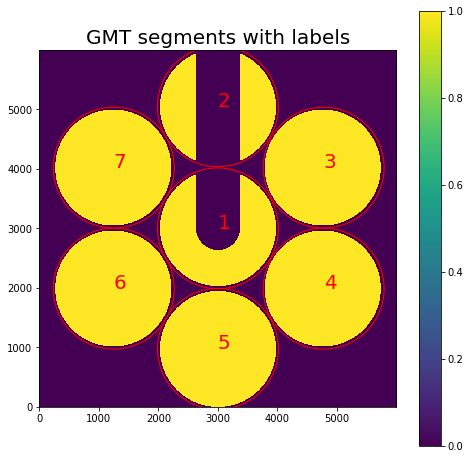

In [4]:
# plt.imshow(gmt_pupil, origin = 'lower')
# plt.colorbar()
# plt.show()
# plt.imshow(gmt_asym_pupil, origin = 'lower')
# plt.colorbar()
# plt.title('GMT Asymmetric Phase mask', fontsize = 20)
# plt.savefig('gmt_phase_mask.jpg')
# plt.show()
# Segment coord x=4777 y=1987, r=1015
seg1 = ([4777,1987])
seg_list = [[3000,3000],[3000,5050],[4777,4020],[4777,1987],[3000,975],[1250,1987],[1250,4020]]
r = 1015
plt.imshow(gmt_asym_amp, origin = 'lower')
for i in range(len(seg_list)):
    seg = plt.Circle((seg_list[i][0],seg_list[i][1]),r,color='r',fill=False)
    plt.text(seg_list[i][0],seg_list[i][1],str(i+1), color = 'r', fontsize = 20)
    plt.gca().add_artist(seg)
plt.colorbar()
plt.title('GMT segments with labels',fontsize = 20)
# plt.savefig('GMT_seg_choice.jpg')
plt.show()

In [5]:
gmt_field, pupil_grid = imgarr_to_field(gmt_pupil)
asym_phase_field, asym_phase_grid = imgarr_to_field(gmt_asym_pupil)
asym_amp_field, asym_amp_grid = imgarr_to_field(gmt_asym_amp)

In [7]:
gmt_wf_pupil = asym_amp_field * (1e-1+np.exp(1j*asym_phase_field)+np.exp(-1j*asym_phase_field))
# gmt_blah = comb_amp_phase(amp=asym_amp_field,phase=asym_phase_field)
# imshow_fiellog(plot(d(gmt_bla)h)
# plt.colorba# r()
# plt.title('Combined Amp and Phase pupil plane',fontsize = 20)
# # plt.savefig('GMT_amp_phase_com# b.jpg')
# plt.show()

In [8]:
gmt_wf_pupil_top = asym_amp_field * np.exp(1j*asym_phase_field) 
gmt_wf_pupil_leak = asym_amp_field * 1e-1 
gmt_wf_pupil_bottom = asym_amp_field * np.exp(-1j*asym_phase_field) 

In [9]:
# wavef = Wavefront(gmt_blah,1)
# gmt_focal_grid = make_focal_grid_from_pupil_grid(pupil_grid,16,32)
# prop = FraunhoferPropagator(pupil_grid,gmt_focal_grid)
# focal_image = prop.forward(wavef)

In [10]:
gmt_wf_focal_top = prop_dat_image(gmt_wf_pupil_top,gmt_wf_pupil_top.grid)
gmt_wf_focal_leak = prop_dat_image(gmt_wf_pupil_leak,pupil_grid)
gmt_wf_focal_bottom = prop_dat_image(gmt_wf_pupil_bottom,pupil_grid)

In [11]:
# top = np.abs(gmt_wf_focal_top.intensity)**2
top = gmt_wf_focal_top.intensity
# top /= top.max()
# top = gmt_wf_focal_top.intensity / gmt_wf_focal_top.intensity.max()
# leak = np.abs(gmt_wf_focal_leak.intensity)**2
leak = gmt_wf_focal_leak.intensity
# leak /= leak.max()
# leak = gmt_wf_focal_leak.intensity / gmt_wf_focal_leak.intensity.max()
# bottom = np.abs(gmt_wf_focal_bottom.intensity)**2
bottom = gmt_wf_focal_bottom.intensity
# bottom /= bottom.max()
# bottom = gmt_wf_focal_bottom.intensity / gmt_wf_focal_bottom.intensity.max()
img = top + bottom + leak

Text(0.5, 1.0, 'Combined mask focal plane')

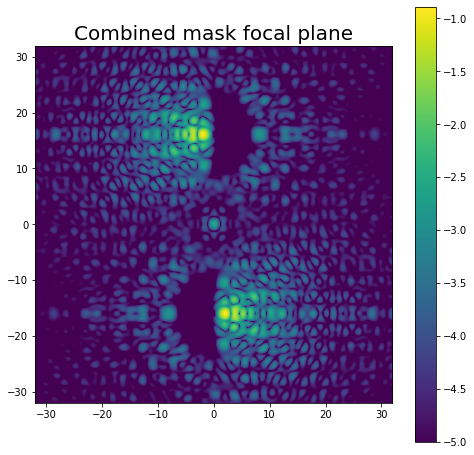

In [12]:
# imshow_field(log_plot(focal_image), vmin = -5)
imshow_field(np.log10(img),vmin=-5)
plt.colorbar()
plt.title('Combined mask focal plane',fontsize = 20)
# plt.savefig('GMT_focal_plane.jpg')
# plt.plot()

In [13]:
fake_grid = gmt_wf_focal_bottom.grid

In [14]:
asym_focal_grid = make_focal_grid_from_pupil_grid(asym_amp_grid,16,32)
asym_wavefront = Wavefront(asym_phase_field,1)
asym_prop = FraunhoferPropagator(asym_amp_grid,asym_focal_grid)
asym_focal_image = asym_prop.forward(asym_wavefront)

In [15]:
# imshow_field(log_plot(asym_focal_image),
#              vmin = -5)
# plt.colorbar()
# # plt.savefig('gmt_asym_focal.jpg')
# plt.plot()

In [16]:
comb_wf = Wavefront(gmt_wf_pupil,1)
# comb_prop = FraunhoferPropagator()
comb_focal_image = asym_prop.forward(comb_wf)

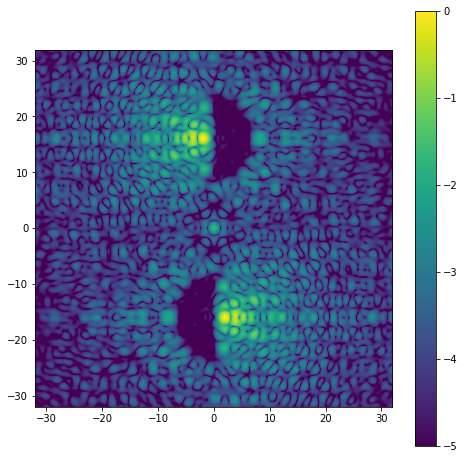

In [17]:
imshow_field(log_plot(comb_focal_image),vmin=-5)
plt.colorbar()
# plt.title()
plt.show()

In [18]:
# Segment coord x=4777 y=1987, r=1015
single_segment = circle_mask(gmt_asym_amp,seg1[0],seg1[1],r)
# plt.imshow(single_segment)
single_segment_full = single_segment * gmt_asym_amp
# plt.imshow(single_segment_full,origin='lower')
# plt.colorbar()
# plt.show()


In [19]:
lam = 532. #* u.nm
del_x = 30. #* u.nm
phase = 2. * np.pi * (del_x / lam)
# phase = del_x / lam
# print(type(float(phase)))
piston_single_segment = np.exp(1j* single_segment_full * phase)
#Stable for some reason
# piston_single_segment = np.exp(single_segment_full * 0.35)
# print(piston_single_segment.max())
# plt.imshow(piston_single_segment,origin='lower')
# plt.colorbar()
# imshow_field(piston_single_segment)

In [20]:
# GMT_piston_test = gmt_asym_amp
# plt.imshow(piston_single_segment,origin='lower')
# plt.colorbar()
# plt.show()

In [21]:
pist1 ,pist_grid= imgarr_to_field(gmt_asym_amp)

In [22]:
pist_test_comb = comb_amp_phase(amp=pist1,phase=asym_phase_field) * piston_single_segment.ravel()

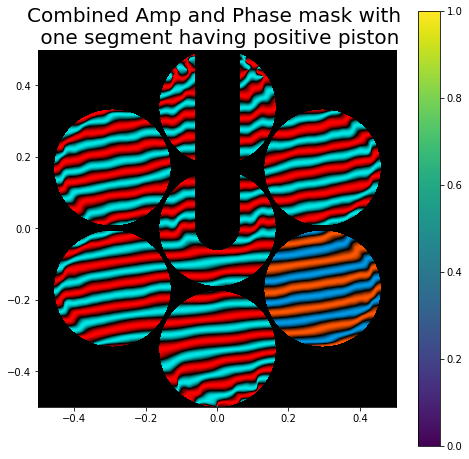

In [23]:
imshow_field(pist_test_comb)
plt.title('Combined Amp and Phase mask with \n one segment having positive piston',fontsize = 20)
plt.colorbar()
# plt.savefig('Seg_pist_comb.jpg')

In [24]:
# pist_focal_grid = 
pist_test_wf = Wavefront(pist_test_comb,1)
pist_test_prop = FraunhoferPropagator(pist_grid,asym_focal_grid)
pist_test_img = pist_test_prop.forward(pist_test_wf)

In [25]:
# imshow_field(log_plot(pist_test_img),vmin=-5)
# plt.colorbar()
# plt.title('Focal plane with negative Piston',fontsize = 20)
# plt.savefig('pist_focal_plane.jpg')

In [26]:
# imshow_field(log_plot(pist_test_img) - log_plot(comb_focal_image))
# plt.colorbar()
# plt.title('Difference in intensity of reference\n image and piston image',fontsize = 20)
# # plt.savefig('focal_plane_diff.jpg')

In [27]:
neg_piston_single_segment = np.exp(-1j* single_segment_full * phase)
neg_pist_test_comb = comb_amp_phase(amp=pist1,phase=asym_phase_field) * neg_piston_single_segment.ravel()

In [28]:
# imshow_field(neg_pist_test_comb)
# plt.colorbar()
# plt.title('Negative piston on one segment',fontsize = 20)
# plt.savefig('neg_pist.jpg')

In [29]:
neg_pist_test_wf = Wavefront(neg_pist_test_comb,1)
neg_pist_test_prop = FraunhoferPropagator(pist_grid,asym_focal_grid)
neg_pist_test_img = pist_test_prop.forward(neg_pist_test_wf)

Text(0.5, 1.0, '$I_{min} - I_{max}$ of piston on one segement')

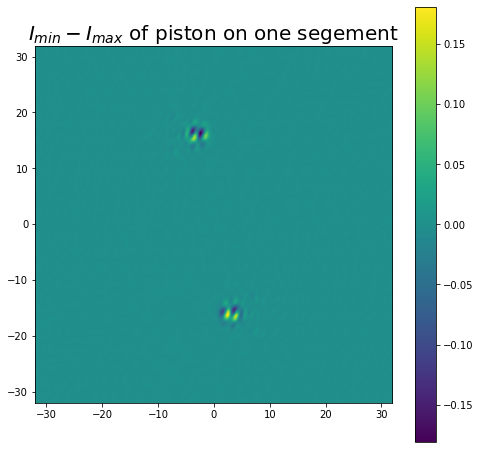

In [30]:
# Do not do log scale
# imshow_field((pist_test_img.intensity / pist_test_img.intensity.max()) - (neg_pist_test_img.intensity / neg_pist_test_img.intensity.max()))
imshow_field(plus_minus_diff(pist_test_img,neg_pist_test_img))
plt.colorbar()
plt.title('$I_{min} - I_{max}$ of piston on one segement',fontsize = 20)
# plt.savefig('I_diff.jpg')

971.744006976199


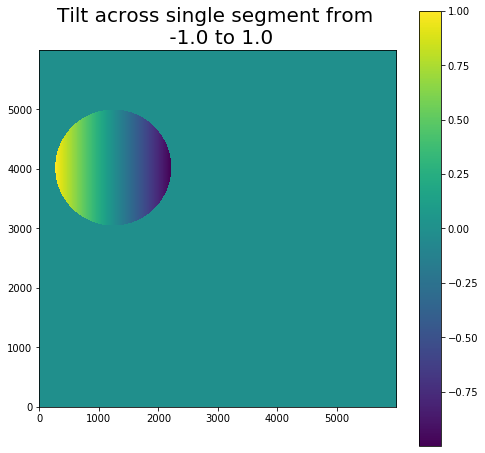

In [37]:
tip_single_seg_test = segment_selector(gmt_asym_amp,seg=7)
tip, tilt = np.mgrid[-np.shape(tip_single_seg_test)[0]/2:np.shape(tip_single_seg_test)[0]/2,-np.shape(tip_single_seg_test)[1]/2:np.shape(tip_single_seg_test)[1]/2]
tilt_im = tip_single_seg_test * -tilt
tilt_im_norm = tilt_im #/ tilt_im.max()
tilt_im_norm_even = np.where(tilt_im_norm == 0,
                            tilt_im_norm !=0, 
                            tilt_im_norm - np.mean(tilt_im_norm[np.nonzero(tilt_im_norm)])
                            )
print(tilt_im_norm_even.max())
tilt_im_norm_even /= tilt_im_norm_even.max()
# print(tilt_im_norm_even.min(),tilt_im_norm_even.max())
plt.imshow(tilt_im_norm_even, origin='lower')
plt.colorbar()
plt.title('Tilt across single segment from \n %.1f to %.1f' % (tilt_im_norm_even.min(),tilt_im_norm_even.max()),fontsize = 20)
# plt.savefig('../images/tip_single_seg.jpg')
plt.show()

In [30]:
tilt_single_segment = np.exp(1j * tilt_im_norm_even)

Text(0.5, 1.0, 'Combined Amplitude and Phase mask \n with Tilt')

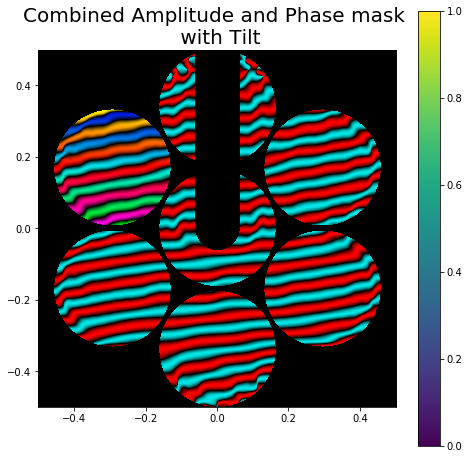

In [35]:
tilt_test = comb_amp_phase(amp=pist1,phase=asym_phase_field) * tilt_single_segment.ravel()
imshow_field(tilt_test)
plt.colorbar()
plt.title('Combined Amplitude and Phase mask \n with Tilt',fontsize = 20)
# plt.savefig('tilt_comb.jpg')

In [37]:
tilt_test_wf = Wavefront(tilt_test,1)
tilt_test_prop = FraunhoferPropagator(pist_grid,asym_focal_grid)
tilt_test_img = tilt_test_prop.forward(tilt_test_wf)

Text(0.5, 1.0, 'Intensity difference with induced tilt')

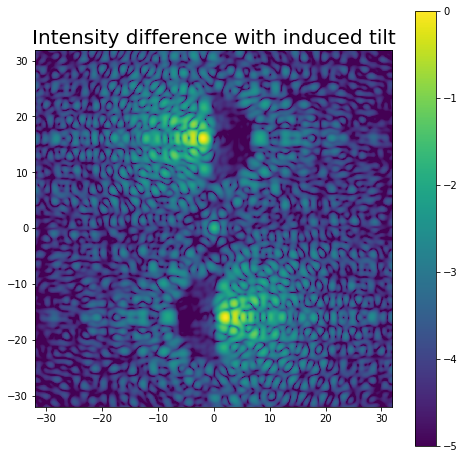

In [38]:
imshow_field(log_plot(tilt_test_img),vmin=-5)
plt.colorbar()
plt.title('Intensity difference with induced tilt',fontsize = 20)
# plt.savefig('Tilt_I_diff.jpg')

In [39]:
neg_tilt_seg = -1 * tilt_im_norm_even

In [40]:
# plt.imshow(neg_tilt_seg,origin='lower')
# plt.colorbar()
print(neg_tilt_seg.max(),neg_tilt_seg.min())
neg_tilt_seg_test = np.exp(1j * neg_tilt_seg)

1.000634318448395 -1.0


In [41]:
neg_tilt_pupil = comb_amp_phase(amp=pist1,phase=asym_phase_field) * neg_tilt_seg_test.ravel()

In [42]:
# imshow_field(neg_tilt_pupil)

In [43]:
neg_tilt_focus = prop_dat_image(neg_tilt_pupil,pist_grid)

Text(0.5, 1.0, 'some lame title')

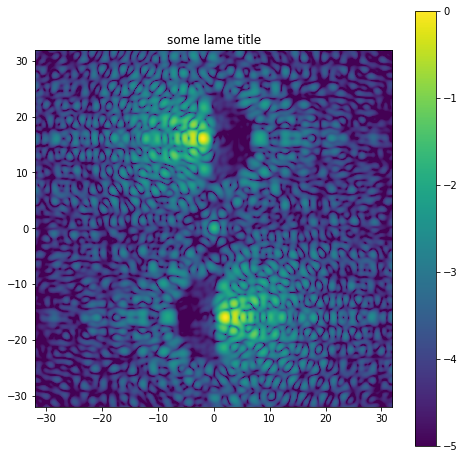

In [44]:
imshow_field(log_plot(neg_tilt_focus),vmin=-5)
plt.colorbar()
plt.title('some lame title')

In [45]:
imshow_field(tilt_test_img.intensity - neg_tilt_focus.intensity)

ValueError: operands could not be broadcast together with shapes (1048576,) (4194304,) 